In [3]:
import numpy as np

# data I/O
data = open('shakespear.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 99992 characters, 62 unique.


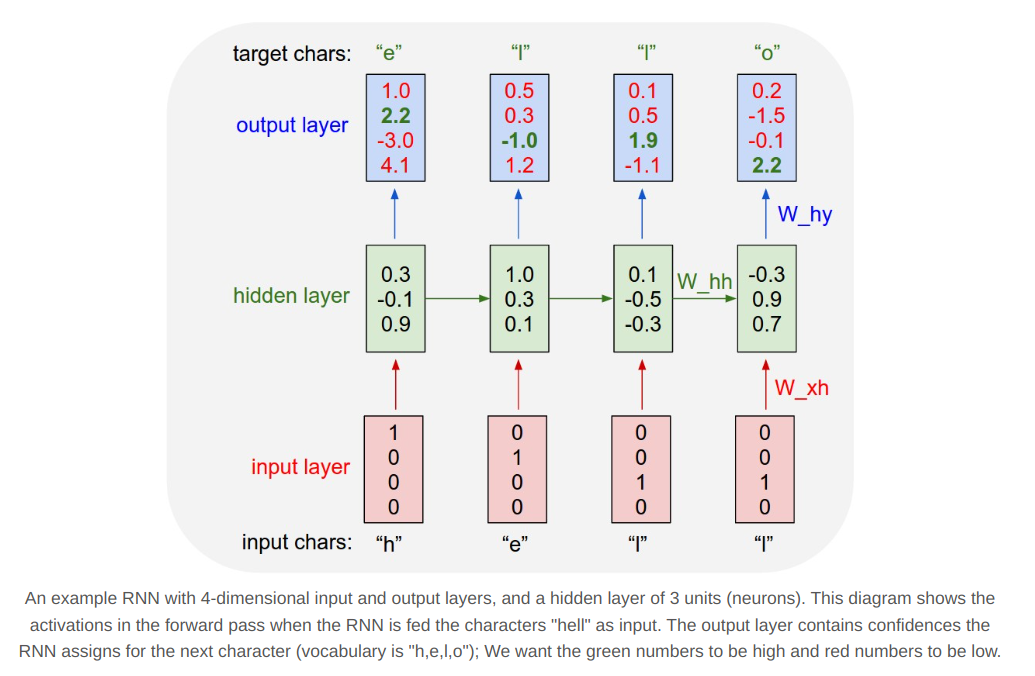

In [4]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [7]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1 # one hot encoding, so 1 corresponds to the word
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [9]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [15]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

----
 hat ave ane my his tima sthagak:
To lued of'w! sinanper:
Thit if beare thy stould the ink of Suchiond maghea'd farting waist of pronout laken brope, may prome
Ssear?

NACAX:
I mull all dorppererobs
Al 
----
iter 0, loss: 103.126129
----
 
Atdt,,
h Hhay ult
Smeedreer e es Sayeid ranke

ams ous e jah,.dd MfpyH: Ieg fuckr ate tmt Se,ody Sain
Bpy ta goat eaiudktag, I:eh tud crry ae uils:hin:re Wmy sol, ooa
gt bt Saum ahis
mee aendtheede t 
----
iter 100, loss: 102.672020
----
 ha abt acd mdvit roo-wae fws rotod uth urh att ter guve, fmmea cid Ittaled oou omy tive akne

OANTRat
I bs tid tud uby ake ods ild ta, bhg ery I
ORe 
Meoland anase bt omt Iy poado tdgerd sowatef ak
Yo 
----
iter 200, loss: 100.465812
----
 id-lenat satees enothehthehald anf t, ag paveust qe dowllond: ban, them is til to trheero,ol toroot sealc btheth ceg
HIDUSog oml bes
AGESf:
Tor teniret vout phomoas toseey
Thend heoe sonotfead 
Sye ho 
----
iter 300, loss: 97.767011
----
 nlet te
la

Huof thuder, toudars
Bu i

KeyboardInterrupt: 

In [14]:
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if True:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if True: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 
  break

----
  of cle ententer, saocpenty hinour me cotermt beaed shoul paihfing,
Fook, art! youtht and wemssistin tite,
That nithaspod home, not never wolquon viough with like my 'Gost;
Over lown I nou ma.
Hus I b 
----
iter 104115, loss: 49.261617
